In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import matplotlib

In [2]:
def calibrate_camera(nx, ny, image_name_mask):
    """
    Calibrate cameara and return camera matrix and distortion coefficients
    """     
    
    #get all images from the calibration folder
    images = glob.glob(image_name_mask)
    
    #define object points and image points
    obj_points = []
    image_points = []
    
    #iterate through all images from the calibration folder
    for image_name in images:
        obj_p = np.zeros((nx * ny, 3), np.float32)
        obj_p[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
            
        image = cv2.imread(image_name)
        
        # Convert image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        #find inner corners of the chessboard
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
        #if corners are determined add this image for the camera calibration
        if ret == True:
            image_points.append(corners)
            obj_points.append(obj_p)

            # Draw and display the corners
            #cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
            #plt.imshow(image)
            #plt.show()
            
    #calibrate camera using collected points and open cv
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, image_points, gray.shape[::-1], None, None)    
    
    return ret, mtx, dist, rvecs, tvecs
    

In [3]:
#define folder with name mask where chessboard images are stored for the camera calibration
image_name_mask = 'camera_cal\calibration*.jpg'

#define number of corners in the image  
nx = 9
ny = 6

#calibrate camera to get camera matrix and distortion cooficients
ret, mtx, dist, rvecs, tvecs = calibrate_camera(nx, ny, image_name_mask)

In [4]:
def undistort(image, mtx, dist):
    """
    Undistort image using camera matrix and distortion coefficients
    """     
    return cv2.undistort(image, mtx, dist, None, mtx)

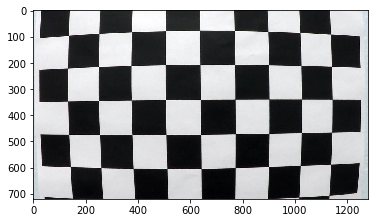

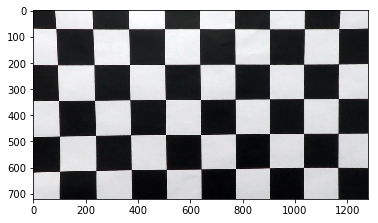

In [5]:
#test undistortion operation on the chessboard image
image_name = 'camera_cal\calibration1.jpg'
image = cv2.imread(image_name)
dst = undistort(image, mtx, dist)
plt.imshow(image)
plt.show()

plt.imshow(dst)
plt.show()

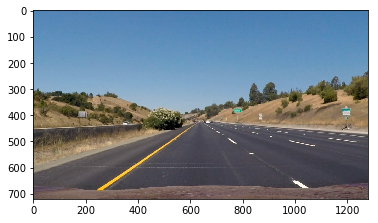

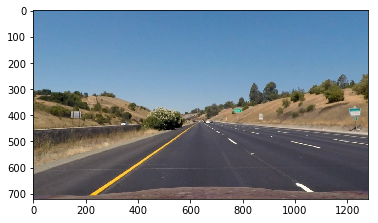

In [6]:
#test undistortion operation on the road image

image_name = 'test_images\straight_lines1.jpg'
image = mpimg.imread(image_name)

plt.imshow(image)
plt.show()
matplotlib.image.imsave('images/road_normal.png', image)

image = undistort(image, mtx, dist)
plt.imshow(image)
plt.show()

matplotlib.image.imsave('images/road_undistorted.png', image)

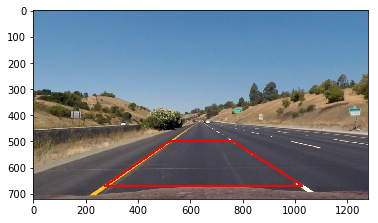

In [7]:
#define rectangular region on the flat stright road to determine perspective transform
image_rect = np.copy(image)

src = np.float32([(275,670), (1030,670), 
                   (766,500), (521,500)])

pts = np.int32(src.reshape((-1,1,2)))

cv2.polylines(image_rect, [pts], True, (255,0,0), thickness=5)

plt.imshow(image_rect)
plt.show()
matplotlib.image.imsave('images/road_region.png', image)

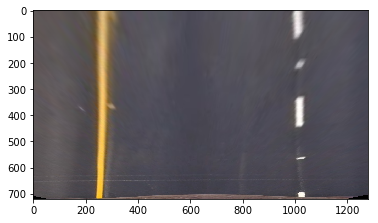

In [8]:
#use coordinatres above and open CV to calculate perspective transform matrix and inversed matrix
dst = np.float32([[250, 700], [1030, 700],
                    [1030, 400], [250, 400]])

#Find matrix
M = cv2.getPerspectiveTransform(src, dst)

#Find inversed matrix
Minv = cv2.getPerspectiveTransform(dst, src)

#Define image shape
image_shape = (1280, 720)

#find car center
car_center = (image_shape[0] / 2, image_shape[1])

a = np.array([car_center], dtype='float32')
a = np.array([a])

pointsOut = cv2.perspectiveTransform(a, M)
center_warped = np.int32(pointsOut[0, 0]) 

def warpPerspective(image):
    """
    Apply perspective transform using determined matrix M.
    """     
    warped = cv2.warpPerspective(image, M, dsize=image_shape)
    return warped

#Restore flat road from the image above 
warped = warpPerspective(image)
plt.imshow(warped)
plt.show()
matplotlib.image.imsave('images/road_perspective.png', image)

In [9]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    Apply SobelX or SobelY operator to the image with the specified kernel and threshold
    """    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grad = cv2.Sobel(gray, cv2.CV_64F, 1 if orient == 'x' else 0, 1 if orient == 'y' else 0, ksize=sobel_kernel)
    grad = np.abs(grad)
    max_grad = np.max(grad)
    grad = np.uint8(grad * 255 / max_grad)
    mask = np.zeros_like(grad, np.float32)
    mask[(grad >= thresh[0]) & (grad <= thresh[1])] = 1
    
    return mask

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    Apply both SobelX or SobelY operators with the specified kernel
    to the image  and use magnitude threshold
    """    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(grad_x * grad_x + grad_y * grad_y)
    max_mag = np.max(mag)
    mag = np.uint8(mag * 255 / max_mag)
    mask = np.zeros_like(mag, np.float32)
    mask[(mag >= mag_thresh[0]) & (mag <= mag_thresh[1])] = 1
    
    return mask

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Apply both SobelX or SobelY operator with the specified kernel to the image, 
    determine gradient direction and use direction threshold
    """    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    grad_x = np.abs(grad_x)
    grad_y = np.abs(grad_y)
        
    dir = np.arctan2(grad_y, grad_x)
    
    mask = np.zeros_like(dir)
    mask[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    
    return mask

def hls_select(image, thresh=(0, 255)):
    """
    Convert image to HLS and select pixels based on Saturation threshold
    """    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    mask = np.zeros_like(s)
    mask[(s >= thresh[0]) & (s <= thresh[1])] = 1
    return mask

In [10]:
class Line():
    def __init__(self):
        #polynomial coefficients for the most recent fit
        self.current_fit = None 
                
        #set of y values to draw
        self.ploty = None 
        
        #set of x values to draw
        self.plotx = None 
                
        # was the line detected in the last iteration?
        self.detected = False  
                
        #distance in meters of vehicle center from the line
        self.line_distance = None 
        
        #radius of curvature in meters
        self.rad = 0 
        
        
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def is_valid(self, previous):
        pos_threshold = 0.2
        
        if (previous is not None) and (np.abs(previous.line_distance - self.line_distance) > pos_threshold):
                  return False
        
        if np.abs(self.rad) < 200.0:
            return False
        
        return True

In [11]:
def find_lines_in_regions(image, nonzerox, nonzeroy, margin, left_fit, right_fit):
  
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return ploty, left_fitx, right_fitx, left_fit, right_fit

def find_lines(image, nwindows=9, good_left_fit=None, good_right_fit=None, show_debug=False):
    # Set the width of the windows +/- margin
    margin = 80
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
        
    #make a copy of input image
    img = np.copy(image)  

    out_img = np.uint8(np.dstack((img, img, img)) * 255)

    #find historgram to determine starting points on thebottom on image
    
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

    midpoint = np.int(histogram.shape[0]/2)

    if show_debug:
        plt.plot(histogram)
        plt.show()
   
    leftx_base = np.argmax(histogram[:midpoint])
    
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(img.shape[0] / nwindows)

    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    if (good_left_fit is not None) and (good_right_fit is not None):
        ploty, left_fitx, right_fitx, left_fit, right_fit = find_lines_in_regions(img, nonzerox, nonzeroy,
                                                                                  margin, good_left_fit, good_right_fit)
    else:
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window + 1) * window_height
            win_y_high = img.shape[0] - window * window_height

            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin

            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Draw the windows on the visualization image
            if show_debug:
                cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 2) 
                cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,0), 2) 

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))

            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)    

        # Generate x and y values for plotting
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

    if show_debug:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
        
    left_line = Line()
    left_line.current_fit = left_fit
    left_line.detected = True
    left_line.ploty = ploty
    left_line.plotx = left_fitx
    
    
    right_line = Line()
    right_line.current_fit = right_fit
    right_line.detected = True
    right_line.ploty = ploty
    right_line.plotx = right_fitx
        
    return left_line, right_line

In [12]:
def calculate_lines_parameters(left_line, right_line):
    ym_per_pix = 30.0 / 720 # meters per pixel in y dimension
    xm_per_pix = 3.4 / 700 # meters per pixel in x dimension
    
    # Determine distances from the car center to the left and right lines
    y_max = np.max(left_line.ploty)
    left_line.line_distance = np.abs(center_warped[0] - left_line.current_fit[0] * y_max ** 2 - left_line.current_fit[1] * y_max - left_line.current_fit[2]) * xm_per_pix
    right_line.line_distance = np.abs(center_warped[0] -  right_line.current_fit[0] * y_max ** 2 - right_line.current_fit[1] * y_max -  right_line.current_fit[2]) * xm_per_pix

    # Fit polinoms in real measurements
    left_fit_cr = np.polyfit(left_line.ploty * ym_per_pix, left_line.plotx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_line.ploty * ym_per_pix,right_line.plotx * xm_per_pix, 2)

    # Determine lines curvature
    y = np.max(left_line.ploty * ym_per_pix)
    left_line.rad = R_curve(left_fit_cr, y)
    right_line.rad = R_curve(right_fit_cr, y)

In [13]:
def pipline(image, step_completed = None):
    
    if (step_completed != None):
        step_completed(image, 'gray', 'initital image')
    
    #undistort initial image
    undist = undistort(image, mtx, dist)
    
    #grad_dir = dir_threshold(undist, sobel_kernel=15, thresh=(0.7, 1.3))
    
    #if (step_completed != None):
    #    step_completed(grad_dir, 'gray', 'directional gradient')
    
    #grad_mag = mag_thresh(undist, sobel_kernel=31, mag_thresh=(50, 255))
    
    #if (step_completed != None):
    #    step_completed(grad_mag, 'gray', 'magnitude gradient')
    
    #combined = np.zeros_like(grad_dir)
    #combined[((grad_mag == 1) & (grad_dir == 1))] = 1
    
    combined = abs_sobel_thresh(undist, orient='x', sobel_kernel=15, thresh=(40, 255))
    
    if (step_completed != None):
        step_completed(combined, 'gray', 'combined gradient')
    
    hls_s = hls_select(undist, thresh=(100, 255))
  
    if (step_completed != None):
        step_completed(hls_s, 'gray', 'HLS (S) color selection')
  
    out_img = np.dstack((hls_s, hls_s, hls_s)) * 255
    
    if (step_completed != None):
        step_completed(out_img, 'gray', 'HLS (S) color selection stacked')
    
    hls_s = abs_sobel_thresh(out_img, orient='x', sobel_kernel=15, thresh=(50, 255))
        
    if (step_completed != None):
        step_completed(hls_s, 'gray', 'HLS (S) + Sobel X')
  
    combined_res = np.zeros_like(hls_s)
    combined_res[((hls_s == 1) | (combined == 1))] = 1
    
    if (step_completed != None):
        step_completed(combined_res, 'gray')
    
    res = warpPerspective(combined_res)
    
    if (step_completed != None):
        step_completed(res, 'gray')
    
    return res, undist

In [14]:
def F_derivate1(coefs, y):
    return 2 * coefs[0] * y + coefs[1]

def F_derivate2(coefs, y):
    return 2 * coefs[0]

def R_curve(coefs, y):
    return ((1 + F_derivate1(coefs, y)**2)**1.5) / F_derivate2(coefs, y)

def draw(image, cmap, text=''):
    print(text)
    plt.imshow(image, cmap=cmap)
    plt.show()
    
def draw_results(warped, undist, left_line, right_line):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.plotx, left_line.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.plotx, right_line.ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Draw right and left lines
    cv2.polylines(color_warp, [np.int32(pts_left)], False, (255,0,0), thickness=30)
    cv2.polylines(color_warp, [np.int32(pts_right)], False, (0,0,255), thickness=30)

    # Draw triangle to indicate car center
    center_points = [[center_warped[0] - 50, center_warped[1]], [center_warped[0] + 50, center_warped[1]],
                [center_warped[0], center_warped[1] - 50]]
    cv2.fillPoly(color_warp, np.int_([center_points]), (255,255,255))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)  
    
    # Draw curvature and distacne text
    left_text = 'Left curve radius: {0:.1f}m'.format(left_line.rad)
    right_text = 'Right curve radius: {0:.1f}m'.format(right_line.rad)

    left_center_text = 'Distance to the left line: {0:.1f}m'.format(left_line.line_distance)
    right_center_text = 'Distance to the right line: {0:.1f}m'.format(right_line.line_distance)

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, left_text, (50, 50), font, fontScale = 0.8, color = (255,255,255), thickness=2)
    cv2.putText(result, right_text, (50, 100), font, fontScale = 0.8, color = (255,255,255), thickness=2)

    cv2.putText(result, left_center_text, (650, 50), font, fontScale = 0.8, color = (255,255,255), thickness=2)
    cv2.putText(result, right_center_text, (650, 100), font, fontScale = 0.8, color = (255,255,255), thickness=2)

    return result

In [15]:
def process_image(image, debug = False):
    res_image, undist = pipline(image, step_completed = draw if debug else None)

    left_line, right_line = find_lines(res_image, show_debug=debug)
    
    calculate_lines_parameters(left_line, right_line)
    
    result = draw_results(res_image, undist, left_line, right_line)
    
    return result, left_line, right_line

initital image


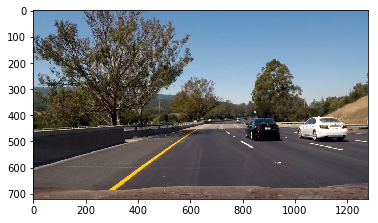

combined gradient


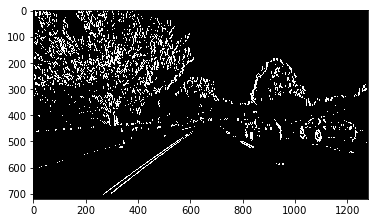

HLS (S) color selection


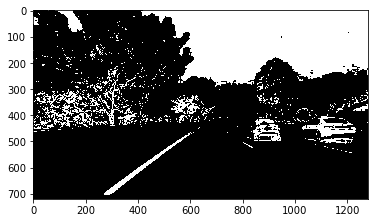

HLS (S) color selection stacked


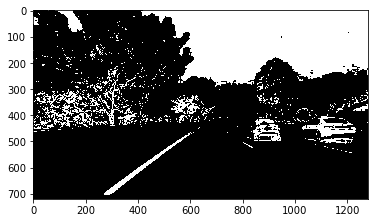

HLS (S) + Sobel X


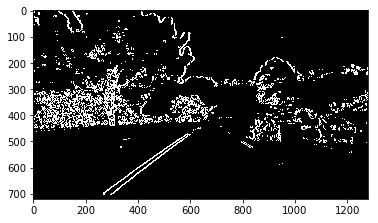

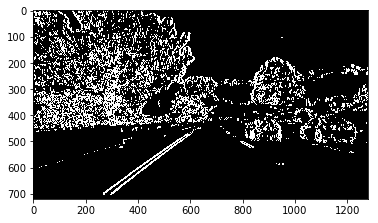

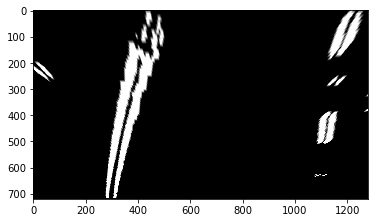

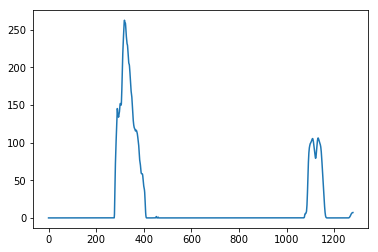

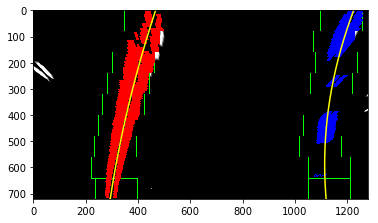

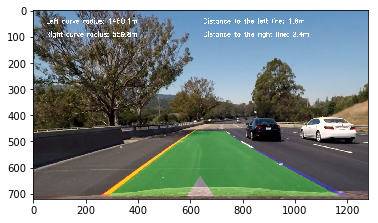

In [16]:
image_name = 'test_images/test6.jpg'
image = mpimg.imread(image_name)

result, left_line, right_line = process_image(image, debug = True)

plt.imshow(result)
plt.show()

matplotlib.image.imsave('images/result_sample1.png', result)

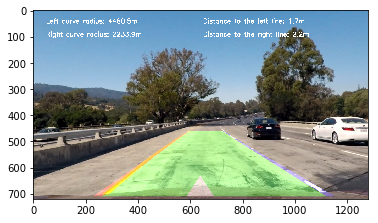

In [17]:
image_name = 'test_images/test1.jpg'
image = mpimg.imread(image_name)

result, left_line, right_line = process_image(image, debug = False)

plt.imshow(result)
plt.show()

matplotlib.image.imsave('images/result_sample1.png', result)

In [18]:
#prepare environment to work with video
import imageio
imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
class ClipContext():
    def __init__(self):
        self.previous_left_line = None
        self.previous_right_line = None
        self.good_left_fit = None
        self.good_right_fit = None
        self.good_left_frame = 0
        self.good_right_frame = 0
        self.current_frame = 0
        self.frame_treshlold = 10
    
    def process_frame(self, image):
        res_image, undist = pipline(image)
        left_line, right_line = find_lines(res_image, good_left_fit=self.good_left_fit, 
                                           good_right_fit=self.good_right_fit, show_debug=False)
        
        calculate_lines_parameters(left_line, right_line)
        
        if left_line.is_valid(self.previous_left_line):
            self.previous_left_line = left_line
            self.good_left_fit = self.previous_left_line.current_fit
            self.good_left_frame = self.current_frame
        
        if right_line.is_valid(self.previous_right_line):
            self.previous_right_line = right_line
            self.good_right_fit = self.previous_right_line.current_fit
            self.good_right_frame = self.current_frame
    
        #reset memory if no good line find for 10 frames 
        if self.current_frame - self.good_left_frame > self.frame_treshlold:
            #reset left line
            self.previous_left_line = None
            self.good_left_fit = None
        
        if self.current_frame - self.good_right_frame > self.frame_treshlold:
            #reset left line
            self.previous_right_line = None
            self.good_right_fit = None
            
        result = draw_results(res_image, undist, 
                              self.previous_left_line if self.previous_left_line is not None else left_line,
                              self.previous_right_line if self.previous_right_line is not None else right_line)
 
        #increase frame
        self.current_frame += 1
        
        return result

In [20]:
def process_video(clip_input, clip_output):
    context = ClipContext()
    clip1 = VideoFileClip(clip_input)
    white_clip = clip1.fl_image(context.process_frame)
    %time white_clip.write_videofile(clip_output, audio=False)
    del clip1.reader
    del clip1

In [21]:
clip1_name = "project_video.mp4"
white_output = 'project_video_updated.mp4'
process_video(clip1_name, white_output)

[MoviePy] >>>> Building video project_video_updated.mp4
[MoviePy] Writing video project_video_updated.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:04<00:00,  8.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_updated.mp4 

Wall time: 3min 5s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [23]:
clip1_name = "challenge_video.mp4"
white_output = 'challenge_video_updated.mp4'
process_video(clip1_name, white_output)

[MoviePy] >>>> Building video challenge_video_updated.mp4
[MoviePy] Writing video challenge_video_updated.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [01:08<00:00,  6.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_updated.mp4 

Wall time: 1min 8s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))